# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22399)

In [7]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

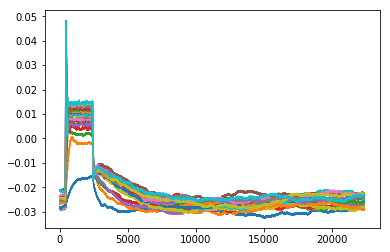

In [8]:
plot(Vout.transpose());

#### Get positive injection current

In [9]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

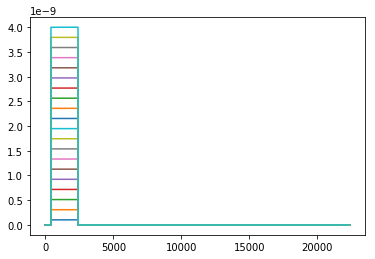

In [10]:
plot(Ic.transpose());

#### Get white noise injection

In [11]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

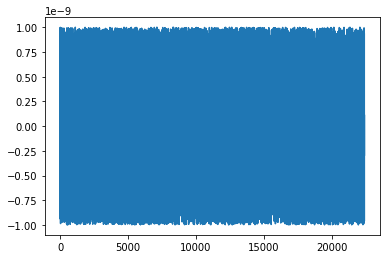

In [12]:
plot(Inoise);

#### Get V from white noise

In [13]:
Vnoise = df_wn_v.to_numpy()
Vnoise = Vnoise[:, 1:].transpose()[0]

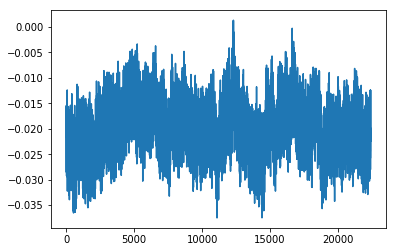

In [14]:
plot(Vnoise);

### Concatinate the data

In [15]:
np.shape(Vnoise)

(22400,)

In [16]:
np.shape(Vout)

(20, 22399)

In [18]:
output = np.concatenate((Vout, [Vnoise[:-1]]))
np.shape(output)

(21, 22399)

In [19]:
input_cur = np.concatenate((Ic, [Inoise]))
np.shape(input_cur)

(21, 22400)

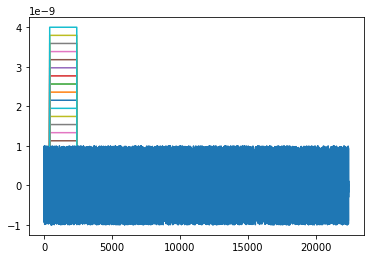

In [20]:
plot(input_cur.transpose());

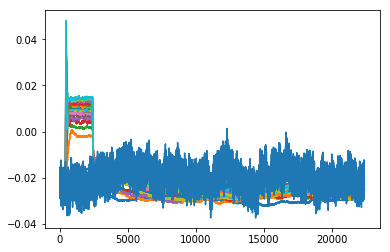

In [21]:
plot(output.transpose());

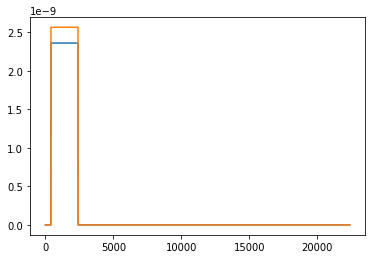

In [22]:
plot(input_cur[11:13].transpose())

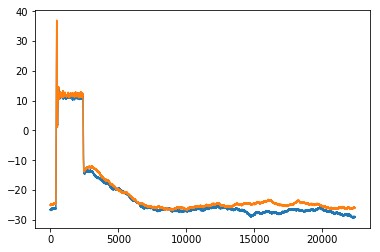

In [23]:
plot((output[11:13]/1e-3).transpose());

## Build a model

In [24]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
# C = 130*pF,
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)
# gL = 1/142*1/Mohm)

In [25]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [26]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

In [27]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)

In [28]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur[11:13] * amp, output=output[11:13]/1e-3 * volt, dt=dt,
                        method='exponential_euler',
                        g_k=[10e-3*siemens, 10e2*siemens],
                        kn = [5*mV, 20*mV],
                        Vn = [-20*mV, 20*mV],
                        Ek = [-100*mV, 0*mV],
                        taun=[10e-2*ms, 100*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=1, n_samples=30, optimizer=n_opt, metric=None)

round 0 with error 566.9234561501627
parameters: {'g_k': 344.60120152379136, 'taun': 0.050268939667040734, 'kn': 0.014367687801921672, 'Ek': -0.07438745107825118, 'Vn': 0.000794328960067294}


In [29]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
# C = 300*pF,
# EL = -30*mV,
# gL = 1/50*1/Mohm
)

In [45]:
start_scope()
n_opt = NevergradOptimizer(method='NoisyDE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()


In [46]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [47]:
# set_device('cpp_standalone', directory='parallel', clean=False)

In [48]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-1*uS, 1e2*uS],
                        taun=[1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=50, n_samples=30, optimizer=n_opt, metric=None)

index 0 errors minimum: 3.2877768568328375e-05
index 1 errors minimum: 3.674775957953895e-05
index 2 errors minimum: 4.162494157659389e-05
index 3 errors minimum: 2.155158687365432e-05
index 4 errors minimum: 2.6030806272503524e-05
index 5 errors minimum: 2.476109293171553e-05
index 6 errors minimum: 1.7353074449805466e-05
index 7 errors minimum: 1.749463117294831e-05
index 8 errors minimum: 1.5242685065861299e-05
index 9 errors minimum: 1.4331801403350445e-05
index 10 errors minimum: 1.4147900852093919e-05
index 11 errors minimum: 1.3310214928349269e-05
index 12 errors minimum: 1.3329005967632468e-05
index 13 errors minimum: 1.2640818614911829e-05
index 14 errors minimum: 1.2378671829386372e-05
index 15 errors minimum: 1.2088602693071225e-05
index 16 errors minimum: 1.2250834678746253e-05
index 17 errors minimum: 1.2306677930139755e-05
index 18 errors minimum: 1.1984524019179458e-05
index 19 errors minimum: 1.1959609727121831e-05
index 20 errors minimum: 1.1974341801689299e-05
index 2

In [49]:
res

{'g_k': 5.714285954458083e-06,
 'taun': 0.0024875309538889383,
 'kn': 0.01866848352110208,
 'Ek': -0.002957455346546213,
 'C': 1.3943779163401818e-10,
 'gL': 7.2099111440882365e-09,
 'Vn': 0.01784506737513665,
 'EL': -0.02639762114682628}

In [50]:
print('g_k', res['g_k']*siemens)
print('taun', res['taun']*second)

g_k 5.71428595 uS
taun 2.48753095 ms


In [51]:
print('Ek', res['Ek']*volt)
print('C', res['C']*farad)
print('EL', res['EL']*volt)
print('gL', res['gL']*siemens)
print('Vn', res['Vn']*volt)
print('kn', res['kn']*volt)

Ek -2.95745535 mV
C 139.43779163 pF
EL -26.39762115 mV
gL 7.20991114 nS
Vn 17.84506738 mV
kn 18.66848352 mV


In [52]:
# visualization of the results
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -30* mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.99069862, -29.98142125, ..., -25.20900121,
        -25.20900121, -25.20900121],
       [-30.        , -29.99069862, -29.98142125, ..., -25.20900121,
        -25.20900121, -25.20900121],
       [-30.        , -29.99069862, -29.98142125, ..., -25.20900121,
        -25.20900121, -25.20900121],
       ...,
       [-30.        , -29.99069862, -29.98142125, ..., -25.20900121,
        -25.20900121, -25.20900121],
       [-30.        , -29.99069862, -29.98142125, ..., -25.20900121,
        -25.20900121, -25.20900121],
       [-30.        , -29.69027566, -29.49415563, ..., -26.21155994,
        -26.46219291, -26.55287993]])

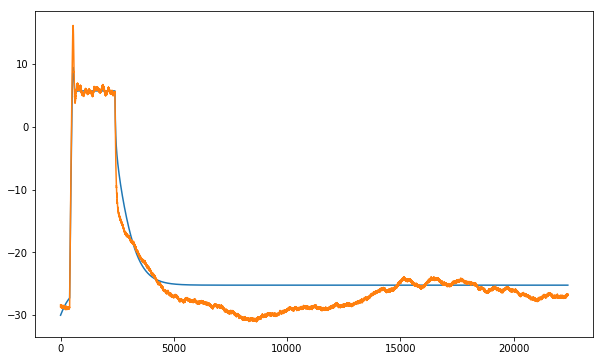

In [53]:
d = 4
plt.figure(figsize=(10,6))
plot(fits[d]/mV)
plot(output[d]/1e-3);

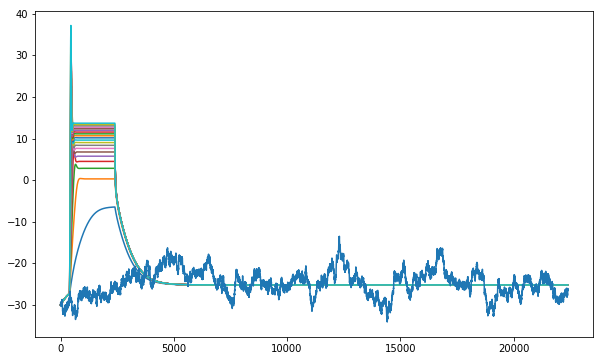

In [54]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

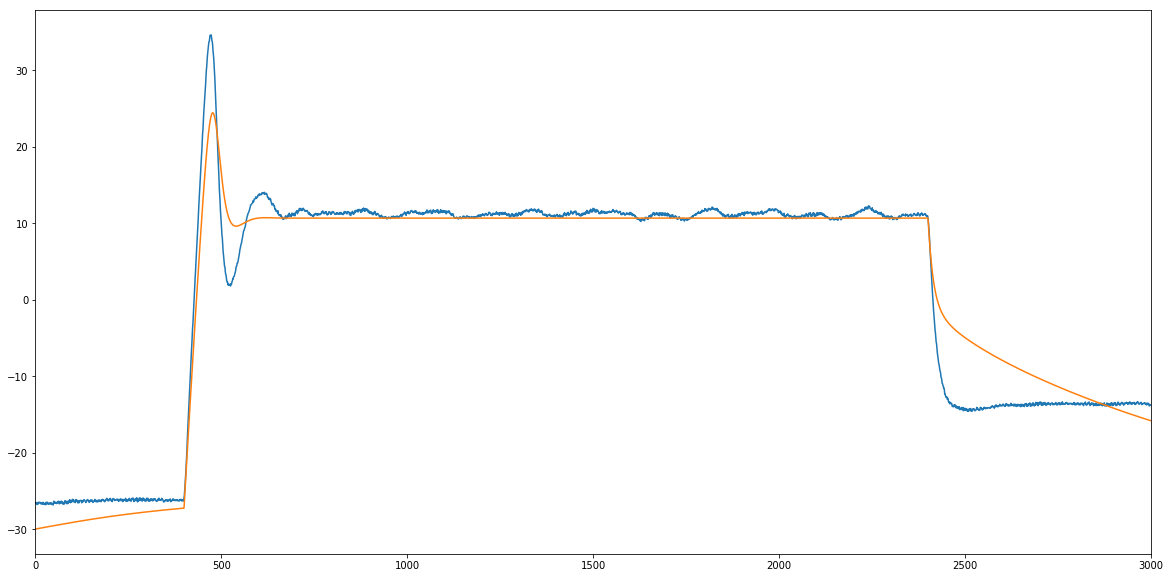

In [55]:
plt.figure(figsize=(20,10))
# plt.ylim(-10,40)
plt.xlim(0,3000)
plot((output[11]/1e-3).transpose());
plot((fits[11]/mV).transpose());

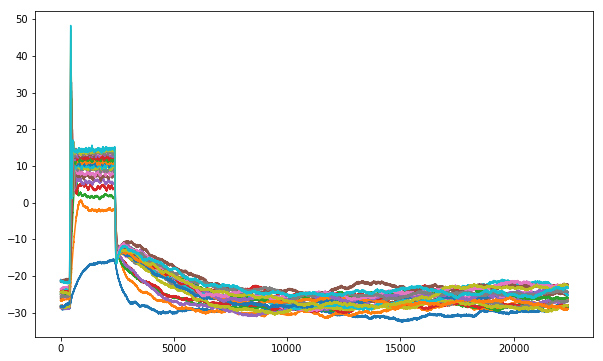

In [56]:
plt.figure(figsize=(10,6))
plot((output[:-1]/1e-3).transpose());

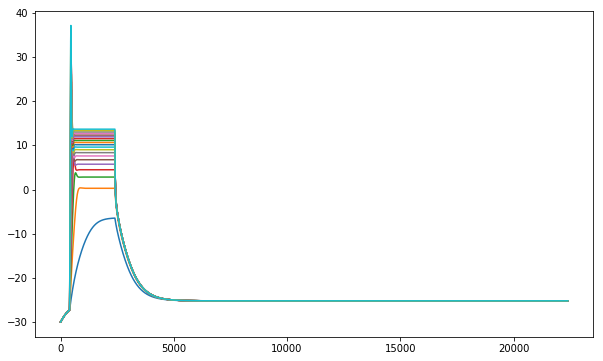

In [57]:
plt.figure(figsize=(10,6))
plot((fits[:-1]/mV).transpose());